# Tabla de Contenidos

1. [Introducción](#Introducción)
2. [Carga de Datos](#Carga-de-Datos)
   - [Librerías](##Librerias)
   - [Descarga y carga de datasets](##Descarga-y-carga-de-datasets)
3. [Preprocesamiento](#Preprocesamiento)
4. [Construcción del Modelo](#Construcción-del-Modelo)
5. [Entrenamiento del Modelo](#Entrenamiento-del-Modelo)
6. [Evaluación del Modelo](#Evaluación-del-Modelo)
7. [Conclusión](#Conclusión)

# Introducción
# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


# Carga de Datos

In [53]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import matplotlib as mplt
import keras_preprocessing
import sys
import sklearn
import pandas as pd

## Librerias

In [54]:
print("Versión de Python:", sys.version)
print("numpy: ",np.__version__)
print("tensorflow: ", tf.__version__)
print("matplotlib: ", mplt.__version__)
print("cv2: ", cv2.__version__)
print("keras_preprocessing: ", keras_preprocessing.__version__)
print("sklearn: ", sklearn.__version__)
print("pandas: ", pd.__version__)

print("GPU: ", tf.config.list_physical_devices('GPU'))
# NVIDIA GTX 1070

Versión de Python: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]
numpy:  1.26.3
tensorflow:  2.10.1
matplotlib:  3.9.0
cv2:  4.9.0
keras_preprocessing:  1.1.2
sklearn:  1.5.1
pandas:  1.5.3
GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [45]:
# Importación de librerías de Keras para construir y entrenar modelos de redes neuronales
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout # Importa capas específicas para la red neuronal
from tensorflow.keras.models import Sequential # Importa la clase Sequential para crear modelos secuenciales
from tensorflow.keras.utils import to_categorical  # Función para convertir etiquetas en formato de una sola categoría
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.callbacks import EarlyStopping # Importa callbacks para guardar el modelo y detener el entrenamiento temprano

# Importación de librerías de keras_preprocessing para preprocesamiento de imágenes
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator # Importa el generador de imágenes para preprocesamiento y aumento de datos

# Importación de una función para cargar modelos previamente guardados
from keras.models import load_model # Importa la función para cargar un modelo previamente guardado

# Importación de una función para convertir imágenes a escala de grises
from skimage.color import rgb2gray

# Importación de matplotlib para la visualización de datos
import matplotlib.pyplot as plt

# Importación de time para medir el tiempo de ejecución
import time

# Importación de métricas de sklearn para evaluar el rendimiento del modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams["figure.figsize"] = (20,6)

## Descarga y carga de datasets

In [11]:
# Primero, bajamos los datos de entrenamiento
#.utils.get_file(fname="simpsons_train.tar.gz", 
                     #origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

In [8]:
# Hacemos lo mismo con los datos de test
#.utils.get_file(fname="simpsons_test.tar.gz", 
                     #origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
#!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [ ]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf C:/.keras/datasets/simpsons_test.tar.gz -C C:/.keras/datasets

In [28]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a estandarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [46]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    images_info = []
  
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        images_info.append((character, len(images)))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train), images_info

In [47]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    
    for filename in glob.glob(dirname + '/*.*'):
        # char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        base_filename = os.path.basename(filename)
        char_name = "_".join(base_filename.split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            if image is None:
                print(f"Error al leer la imagen: {filename}")
                continue
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    
    return np.array(X_test), np.array(y_test)


In [52]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "C:/.keras/datasets/simpsons"

X, y, images_info  = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob


In [51]:
def mostrar_grafica_imagenes_train(images_info):
    print("Información de las imágenes:", images_info)
    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
    
    # Tu información de las imágenes
    # Desempaquetar los datos
    characters, counts = zip(*images_info)

    # Crear la gráfica de dona
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

    wedges, texts = ax.pie(counts, wedgeprops=dict(width=0.3), startangle=-40)

    # Propiedades para las etiquetas y las flechas
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    # Anotaciones en el gráfico
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        label = f"{characters[i]} ({counts[i]})"
        ax.annotate(label, xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title("Número de Imágenes por Personaje en los Simpson")
    plt.show()

Información de las imágenes: [('abraham_grampa_simpson', 913), ('apu_nahasapeemapetilon', 623), ('bart_simpson', 1342), ('charles_montgomery_burns', 1193), ('chief_wiggum', 986), ('comic_book_guy', 469), ('edna_krabappel', 457), ('homer_simpson', 2246), ('kent_brockman', 498), ('krusty_the_clown', 1206), ('lisa_simpson', 1354), ('marge_simpson', 1291), ('milhouse_van_houten', 1079), ('moe_szyslak', 1452), ('ned_flanders', 1454), ('nelson_muntz', 358), ('principal_skinner', 1194), ('sideshow_bob', 877)]


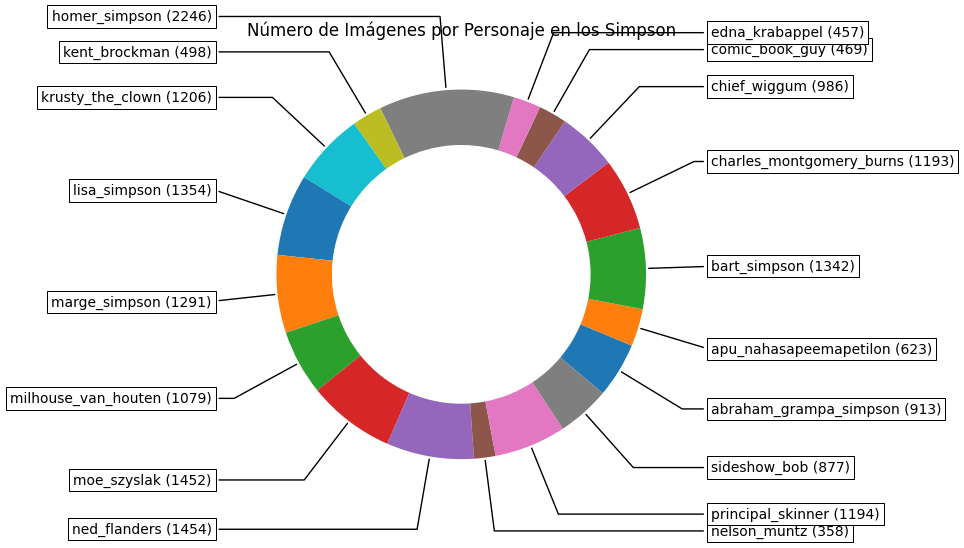

In [35]:
mostrar_grafica_imagenes_train(images_info=images_info)

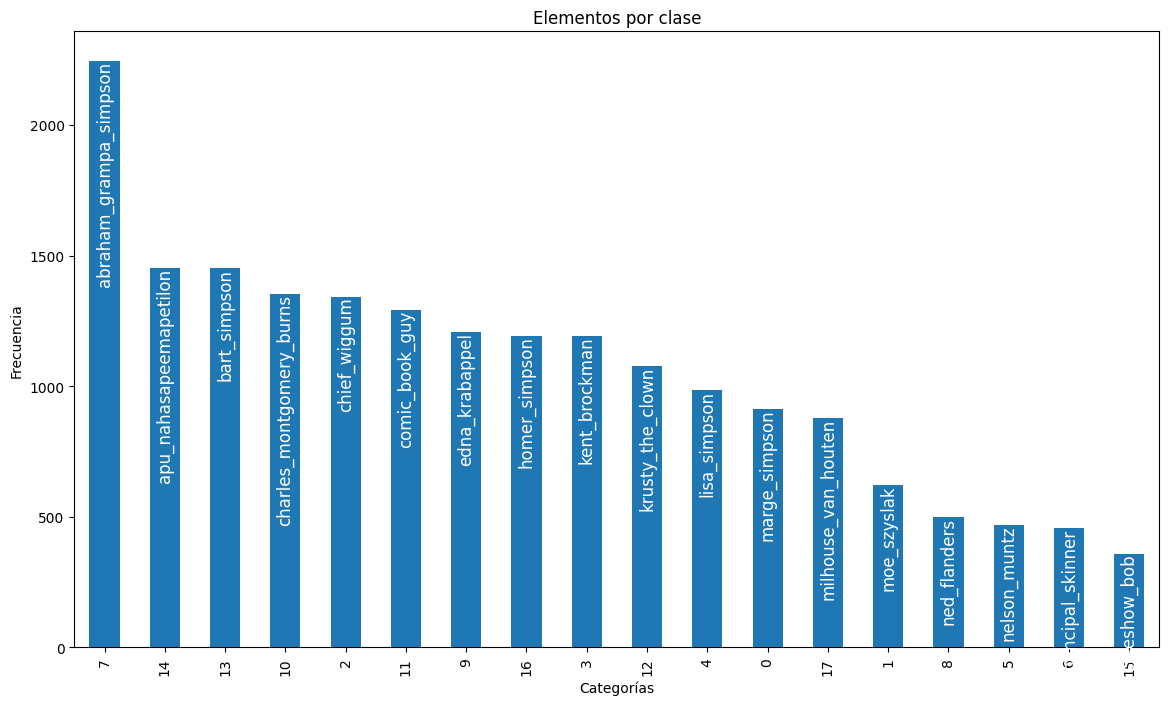

In [67]:
# Contar frecuencias y crear gráfico
ax = pd.Series(list(y)).value_counts().plot(kind='bar', figsize=(14, 8), title="Elementos por clase")

# Contar frecuencias y crear gráfico
ax = pd.Series(list(y)).value_counts().plot(kind='bar', figsize=(14, 8), title="Elementos por clase")

# Configurar etiquetas de los ejes
ax.set_xlabel("Categorías")
ax.set_ylabel("Frecuencia")

# Añadir nombres de las clases al lado derecho de cada barra
for i, value in enumerate(pd.Series(list(y)).value_counts()):
    ax.text(i, value + 0.5, MAP_CHARACTERS[i], ha='center', va='top', fontsize=12, rotation=90, color='white')

plt.show()

In [68]:
DATASET_TEST_PATH_COLAB = "C:/.keras/datasets/simpsons_testset"
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leídas 890 imágenes de test


In [69]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos para ser analizados en vuestro informe:

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

> Analisis de las imagenes cargadas

In [70]:
print("Dimensiones: (Alto, Ancho, No. Canales) ", X_t[0].shape)
print("Valor máximo de los píxeles en las imágenes cargadas: ", X_t.max())
print("Total de Categorias: ", len(MAP_CHARACTERS))

Dimensiones: (Alto, Ancho, No. Canales)  (60, 60, 3)
Valor máximo de los píxeles en las imágenes cargadas:  255
Total de Categorias:  18


# Visualizar imagenes del datasets

Tenemos un conjunto de datos de imágenes con sus etiquetas correspondientes. Para asegurarnos de que las imágenes están correctamente etiquetadas, necesitamos inspeccionarlas visualmente junto con sus etiquetas.

Mostrar una imagen aleatoria

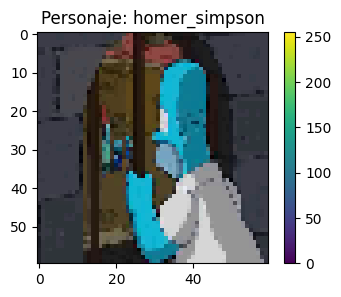

In [98]:
# Seleccionar un índice aleatorio
random_index = np.random.randint(0, len(X))

# Obtener la imagen y la etiqueta correspondientes
image = X[random_index]
label = MAP_CHARACTERS[y[random_index]]

# Mostrar la imagen
plt.figure(figsize=(4, 3))
plt.imshow(image)
plt.colorbar()  # Agregar una barra de colores para indicar la escala de colores
plt.grid(False)
plt.title(f'Personaje: {label}')  # Añadir el título con la etiqueta de la imagen
plt.show()

Mostrar 25 imagenes aleatorias

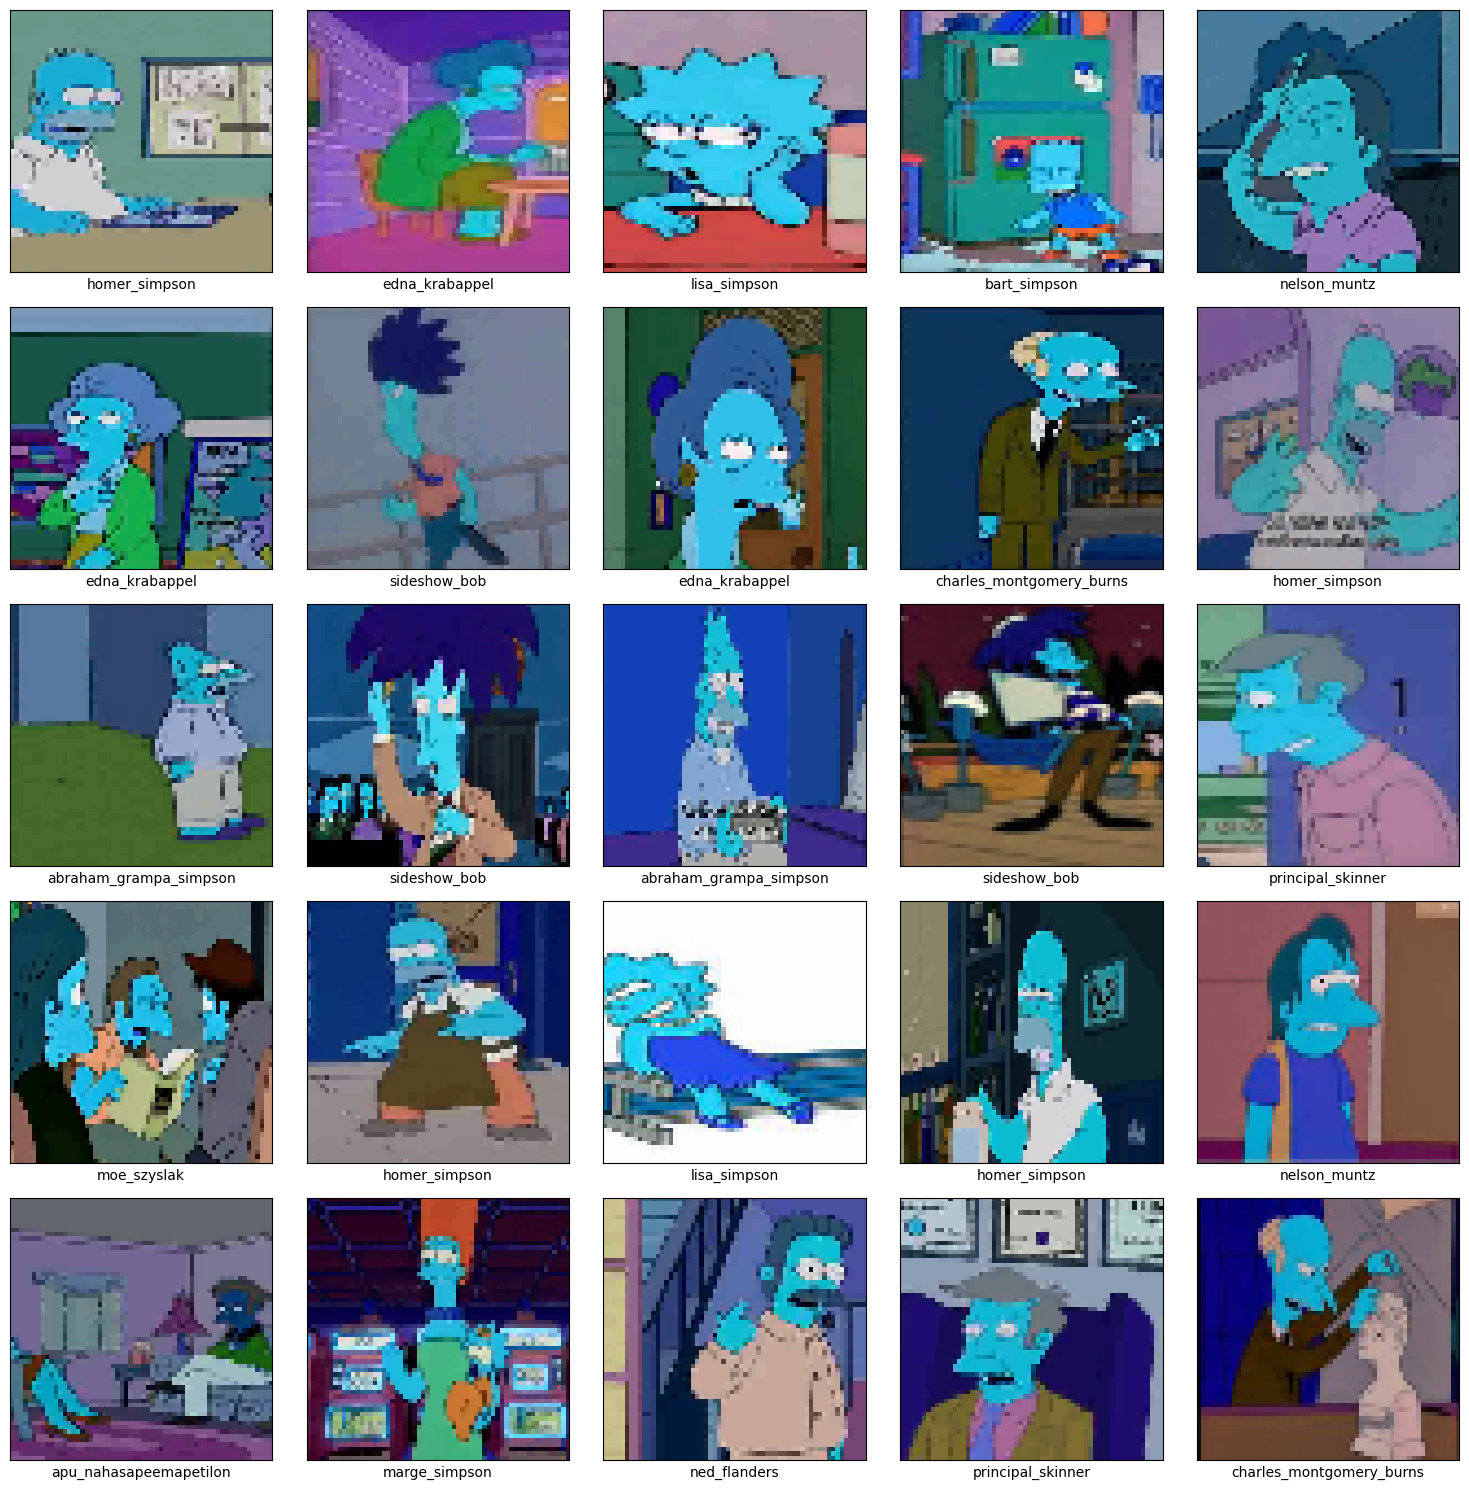

In [111]:
# Número de imágenes a mostrar
num_images = 25

# Seleccionar índices aleatorios
random_indices = np.random.choice(len(X), size=num_images, replace=False)

# Crear la figura
plt.figure(figsize=(15, 15))

# Mostrar las imágenes y sus etiquetas
for i, index in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)  # Crear un subplot en la cuadrícula
    plt.xticks([])  # Ocultar etiquetas del eje x
    plt.yticks([])  # Ocultar etiquetas del eje y
    plt.grid(False)  # Desactivar la cuadrícula
    plt.imshow(X[index], cmap=plt.cm.binary)  # Mostrar la imagen
    plt.xlabel(MAP_CHARACTERS[y[index]], fontsize=10)  # Etiqueta con el nombre de la clase

plt.tight_layout()  # Ajustar el espaciado entre subplots
plt.show()

## Normalización de datos

In [120]:
# Normalización de Datos
X = X / 255.0
X_t = X_t / 255.0

### Preparacion de modelos

In [121]:
import sklearn
import sklearn.preprocessing

num_categories = len(MAP_CHARACTERS) # Obtiene el total de categories

label_encoder = sklearn.preprocessing.LabelEncoder()

# Codificación de datos
# El método fit_transform ajusta el codificador a los datos (y) y luego transforma las etiquetas en valores numéricos.
# Esto es útil para convertir etiquetas de texto en números que puedan ser utilizados por modelos de machine learning.
y_train = label_encoder.fit_transform(y)
y_test = label_encoder.fit_transform(y_t)

# Convertir las etiquetas a formato categórico (one-hot encoding)
# La función to_categorical convierte las etiquetas enteras en matrices binaras (one-hot encoding).
# Esto es útil para tareas de clasificación, donde cada clase se representa como un vector binario.
# Por ejemplo, si hay 18 clases, cada etiqueta se convertirá en un vector de 18 dimensiones.
y_train_tf = tf.keras.utils.to_categorical(y_train, num_categories)
y_test_tf = tf.keras.utils.to_categorical(y_test, num_categories)

In [122]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential

import tensorflow as tf

import collections

from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools


### Modelo Fully Connected (PRINCIPAL)


In [140]:
# CONSTRUCCIÓN DEL MODELO CON REDES NEURONALES CONVULCIONALES CNN

# Configuración
input_shape = (60, 60, 3)
batch_size = 1000 # Numero de lotes
num_classes = len(MAP_CHARACTERS) # 18
epochs = 30 # Iteraciones completas sobre el conjunto de datos

model_fully_connected = keras.models.Sequential()

# Primera capa convolucional
model_fully_connected.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))  # Aplicar 32 filtros de tamaño 3x3
model_fully_connected.add(Activation('relu'))  # Función de activación ReLU

# Segunda capa convolucional con pooling y dropout
model_fully_connected.add(Conv2D(32, (3, 3)))  # Aplicar 32 filtros de tamaño 3x3
model_fully_connected.add(Activation('relu'))  # Función de activación ReLU
model_fully_connected.add(MaxPooling2D(pool_size=(3, 3)))  # Pooling para reducir tamaño
model_fully_connected.add(Dropout(0.2))  # Dropout para evitar sobreajuste

# Tercera capa convolucional con pooling y dropout
model_fully_connected.add(Conv2D(64, (3, 3), padding='same'))  # Aplicar 64 filtros de tamaño 3x3
model_fully_connected.add(Activation('relu'))  # Función de activación ReLU
model_fully_connected.add(Conv2D(64, (3, 3)))  # Aplicar 64 filtros de tamaño 3x3
model_fully_connected.add(Activation('relu'))  # Función de activación ReLU
model_fully_connected.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling para reducir tamaño
model_fully_connected.add(Dropout(0.5))  # Dropout para evitar sobreajuste

# Cuarta capa convolucional
model_fully_connected.add(Conv2D(256, (3, 3), padding='same'))  # Aplicar 256 filtros de tamaño 3x3
model_fully_connected.add(Activation('relu'))  # Función de activación ReLU
model_fully_connected.add(Conv2D(256, (3, 3)))  # Aplicar 256 filtros de tamaño 3x3
model_fully_connected.add(Activation('relu'))  # Función de activación ReLU
model_fully_connected.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling para reducir tamaño

# Aplanar la salida y añadir capas densas
model_fully_connected.add(Flatten())  # Aplanar la salida de las capas convolucionales
model_fully_connected.add(Dense(1024))  # Capa densa (fully connected) con 1024 neuronas
model_fully_connected.add(Activation('relu'))  # Función de activación ReLU

# Capa de salida
model_fully_connected.add(Dense(num_classes, activation='softmax'))  # Capa densa de salida con función de activación softmax

"""
model_sequential = Sequential()

model_sequential.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model_sequential.add(Activation('relu'))

model_sequential.add(Conv2D(32, (3, 3)))
model_sequential.add(Activation('relu'))
model_sequential.add(MaxPooling2D(pool_size=(3, 3)))
model_sequential.add(Dropout(0.2))

model_sequential.add(Conv2D(64, (3, 3), padding='same'))
model_sequential.add(Activation('relu'))

model_sequential.add(Conv2D(64, (3, 3)))
model_sequential.add(Activation('relu'))
model_sequential.add(MaxPooling2D(pool_size=(2, 2)))
model_sequential.add(Dropout(0.5))

model_sequential.add(Conv2D(256, (3, 3), padding='same')) 
model_sequential.add(Activation('relu'))

model_sequential.add(Conv2D(256, (3, 3)))
model_sequential.add(Activation('relu'))
model_sequential.add(MaxPooling2D(pool_size=(2, 2)))
model_sequential.add(Flatten())
model_sequential.add(Dense(1024))
model_sequential.add(Activation('relu'))

model_sequential.add(Dense(num_classes, activation='softmax'))
"""



"\nmodel_sequential = Sequential()\n\nmodel_sequential.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))\nmodel_sequential.add(Activation('relu'))\n\nmodel_sequential.add(Conv2D(32, (3, 3)))\nmodel_sequential.add(Activation('relu'))\nmodel_sequential.add(MaxPooling2D(pool_size=(3, 3)))\nmodel_sequential.add(Dropout(0.2))\n\nmodel_sequential.add(Conv2D(64, (3, 3), padding='same'))\nmodel_sequential.add(Activation('relu'))\n\nmodel_sequential.add(Conv2D(64, (3, 3)))\nmodel_sequential.add(Activation('relu'))\nmodel_sequential.add(MaxPooling2D(pool_size=(2, 2)))\nmodel_sequential.add(Dropout(0.5))\n\nmodel_sequential.add(Conv2D(256, (3, 3), padding='same')) \nmodel_sequential.add(Activation('relu'))\n\nmodel_sequential.add(Conv2D(256, (3, 3)))\nmodel_sequential.add(Activation('relu'))\nmodel_sequential.add(MaxPooling2D(pool_size=(2, 2)))\nmodel_sequential.add(Flatten())\nmodel_sequential.add(Dense(1024))\nmodel_sequential.add(Activation('relu'))\n\nmodel_sequential.add(Dense

### Arquitectura del modelo

In [141]:
model_fully_connected.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 60, 60, 32)        896       
                                                                 
 activation_49 (Activation)  (None, 60, 60, 32)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 58, 58, 32)        9248      
                                                                 
 activation_50 (Activation)  (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 19, 19, 32)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 19, 19, 32)        0         
                                                      

### Compilar el modelo

In [142]:
# Compilación del modelo
model_fully_connected.compile(
    loss='categorical_crossentropy',  # Función de pérdida utilizada para clasificación multi-clase.
                                      # Mide la discrepancia entre las etiquetas verdaderas y las predicciones del modelo.
                                      # Se utiliza cuando las etiquetas están en formato one-hot (vectores binarios).
    optimizer='adam',                 # Optimizador Adam.
                                      # Un optimizador popular que combina las ventajas de AdaGrad y RMSProp.
                                      # Ajusta el tamaño del paso de manera adaptativa y maneja tanto el momento como el gradiente.
    metrics=['accuracy']              # Métrica utilizada para evaluar el rendimiento del modelo.
                                      # 'accuracy' mide la proporción de predicciones correctas entre el total de predicciones.
)

In [143]:

# ENTRENAMIENTO DE MODELO

# Permite guardar en un archivo la epoca para en caso de reiniciar el procesamiento
# comezar por donde quedo
callbacks_fully_connected = [
    keras.callbacks.ModelCheckpoint("model_fully_connected_save_at_{epoch}.keras"),
]

history_fully_connected = model_fully_connected.fit(X,y_train_tf, validation_steps=3, verbose=1,epochs=epochs, batch_size=batch_size,validation_split=0.2, callbacks=callbacks_fully_connected) 

Epoch 1/30
16/16 [==============================] - 5s 240ms/step - loss: 2.8492 - accuracy: 0.0777 - val_loss: 2.8125 - val_accuracy: 0.1090
Epoch 2/30
16/16 [==============================] - 3s 217ms/step - loss: 2.7863 - accuracy: 0.1210 - val_loss: 2.8181 - val_accuracy: 0.1090
Epoch 3/30
16/16 [==============================] - 3s 216ms/step - loss: 2.7708 - accuracy: 0.1212 - val_loss: 2.8038 - val_accuracy: 0.1310
Epoch 4/30
16/16 [==============================] - 3s 214ms/step - loss: 2.6970 - accuracy: 0.1581 - val_loss: 2.5717 - val_accuracy: 0.1867
Epoch 5/30
16/16 [==============================] - 3s 216ms/step - loss: 2.4926 - accuracy: 0.2138 - val_loss: 2.3404 - val_accuracy: 0.2667
Epoch 6/30
16/16 [==============================] - 3s 217ms/step - loss: 2.2767 - accuracy: 0.2989 - val_loss: 2.1309 - val_accuracy: 0.3430
Epoch 7/30
16/16 [==============================] - 3s 217ms/step - loss: 2.0494 - accuracy: 0.3749 - val_loss: 1.8757 - val_accuracy: 0.4227
Epoch 

### Validación del modelo

In [155]:

## La evaluación del modelo se lo realiza con los datos de validación y las métricas de pérdida y precisión

test_loss, test_acc = model_fully_connected.evaluate(X_t,  y_test_tf)

print("------------------------------")
print("Métricas de validación")
print("------------------------------")
print("Pérdida: ",test_loss)
print( "Precisión: ",test_acc)

28/28 [==============================] - 0s 13ms/step - loss: 0.2224 - accuracy: 0.9427
------------------------------
Métricas de validación
------------------------------
Pérdida:  0.2223537415266037
Precisión:  0.9426966309547424


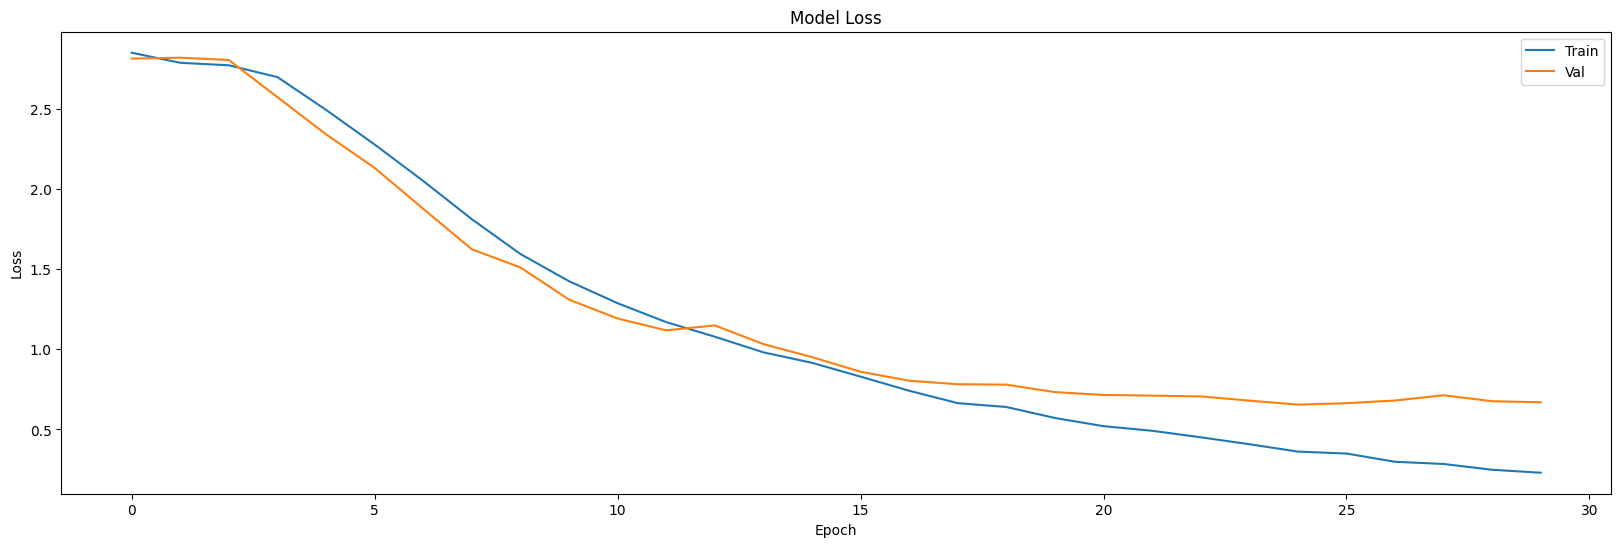

In [156]:
    
plt.plot(history_fully_connected.history['loss'])
plt.plot(history_fully_connected.history['val_loss'])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

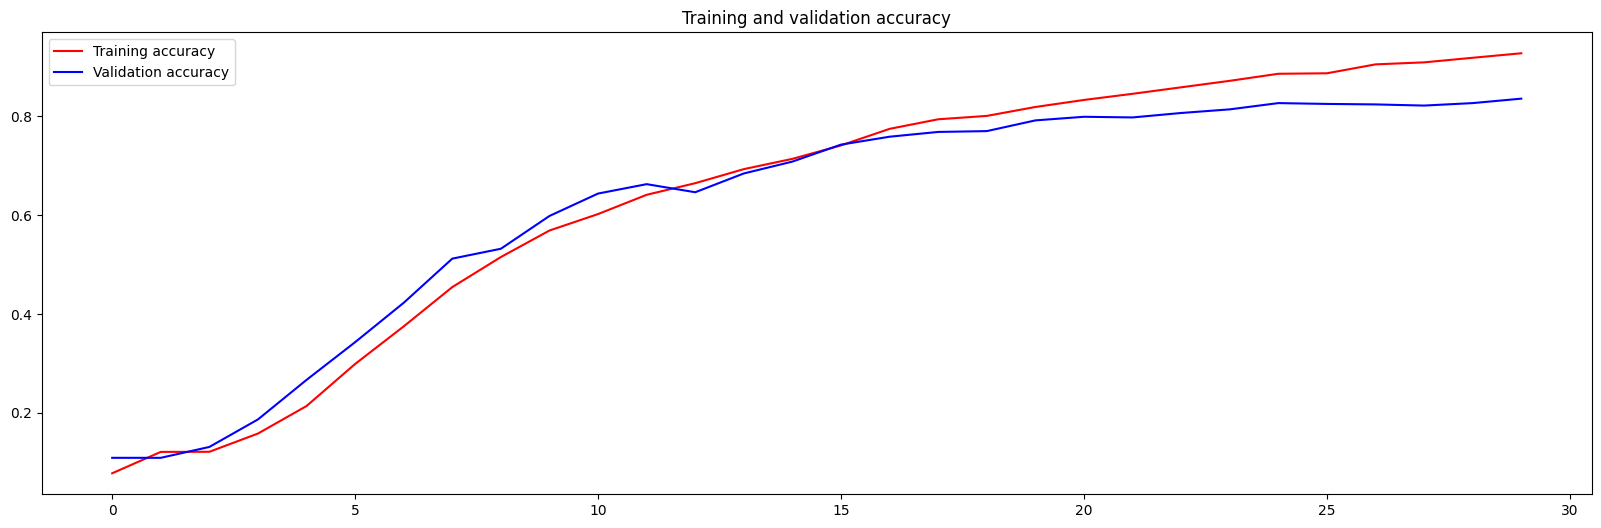

<Figure size 2000x600 with 0 Axes>

In [157]:
# Meticas de precicion
# GRÁFICO DE LA PRECISIÓN CON DATOS DE ENTRENAMIENTO Y DE VALIDACIÓN

import matplotlib.pyplot as plt
acc = history_fully_connected.history['accuracy']
val_acc = history_fully_connected.history['val_accuracy']
loss = history_fully_connected.history['loss']
val_loss = history_fully_connected.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

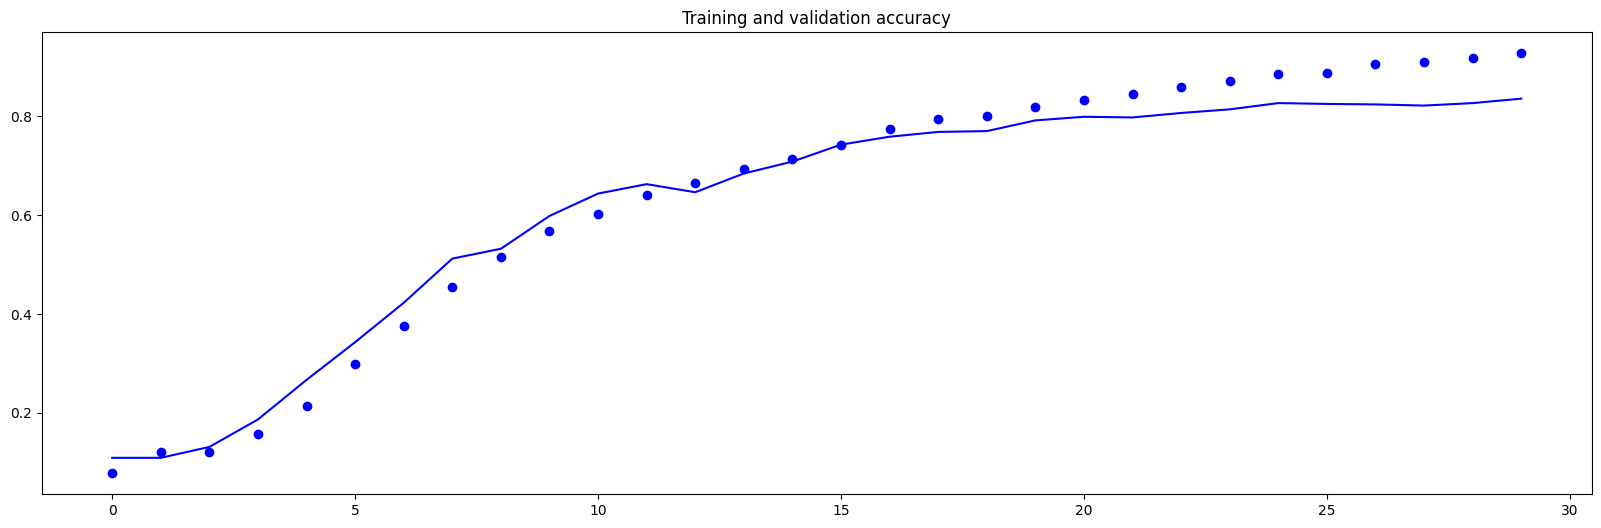

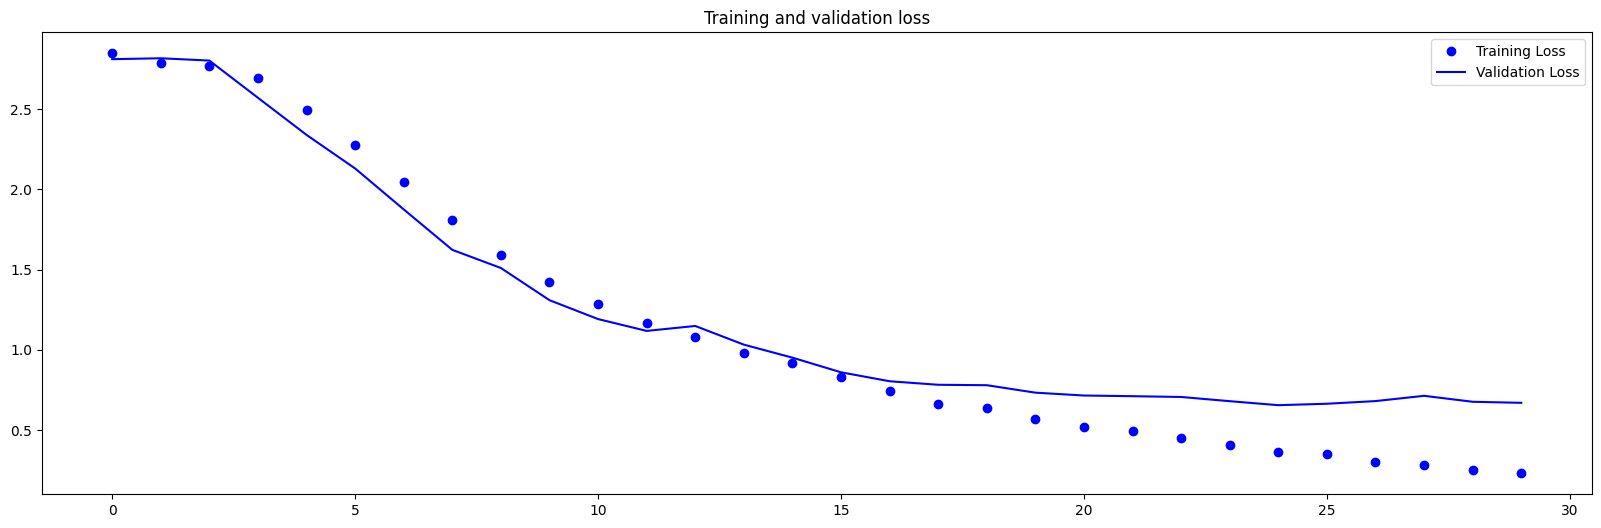

In [158]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [160]:
# Convertir y_test_tf de one-hot a formato entero
y_test = np.argmax(y_test_tf, axis=1)

# Realiza las predicciones con el modelo
y_pred = model_sequential.predict(X_t)
y_pred = np.argmax(y_pred, axis=1)

# Generar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=[MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))])
print(report)

28/28 [==============================] - 0s 8ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.81      0.90        48
  apu_nahasapeemapetilon       0.96      0.98      0.97        50
            bart_simpson       0.84      0.84      0.84        50
charles_montgomery_burns       0.81      0.90      0.85        48
            chief_wiggum       0.98      0.98      0.98        50
          comic_book_guy       0.98      0.92      0.95        49
          edna_krabappel       0.96      0.94      0.95        50
           homer_simpson       0.87      0.94      0.90        50
           kent_brockman       0.94      0.92      0.93        50
        krusty_the_clown       0.96      1.00      0.98        50
            lisa_simpson       0.90      0.90      0.90        50
           marge_simpson       1.00      0.88      0.94        50
     milhouse_van_houten       0.94      1.00      0.97        49
             moe_szysl

https://www.tensorflow.org/tutorials/images/cnn?hl=es-419

In [163]:
# PREDICCIONES

# Se aplica el modelo para los datos de validación
predictions = model_fully_connected.predict(X_t)

28/28 [==============================] - 0s 12ms/step


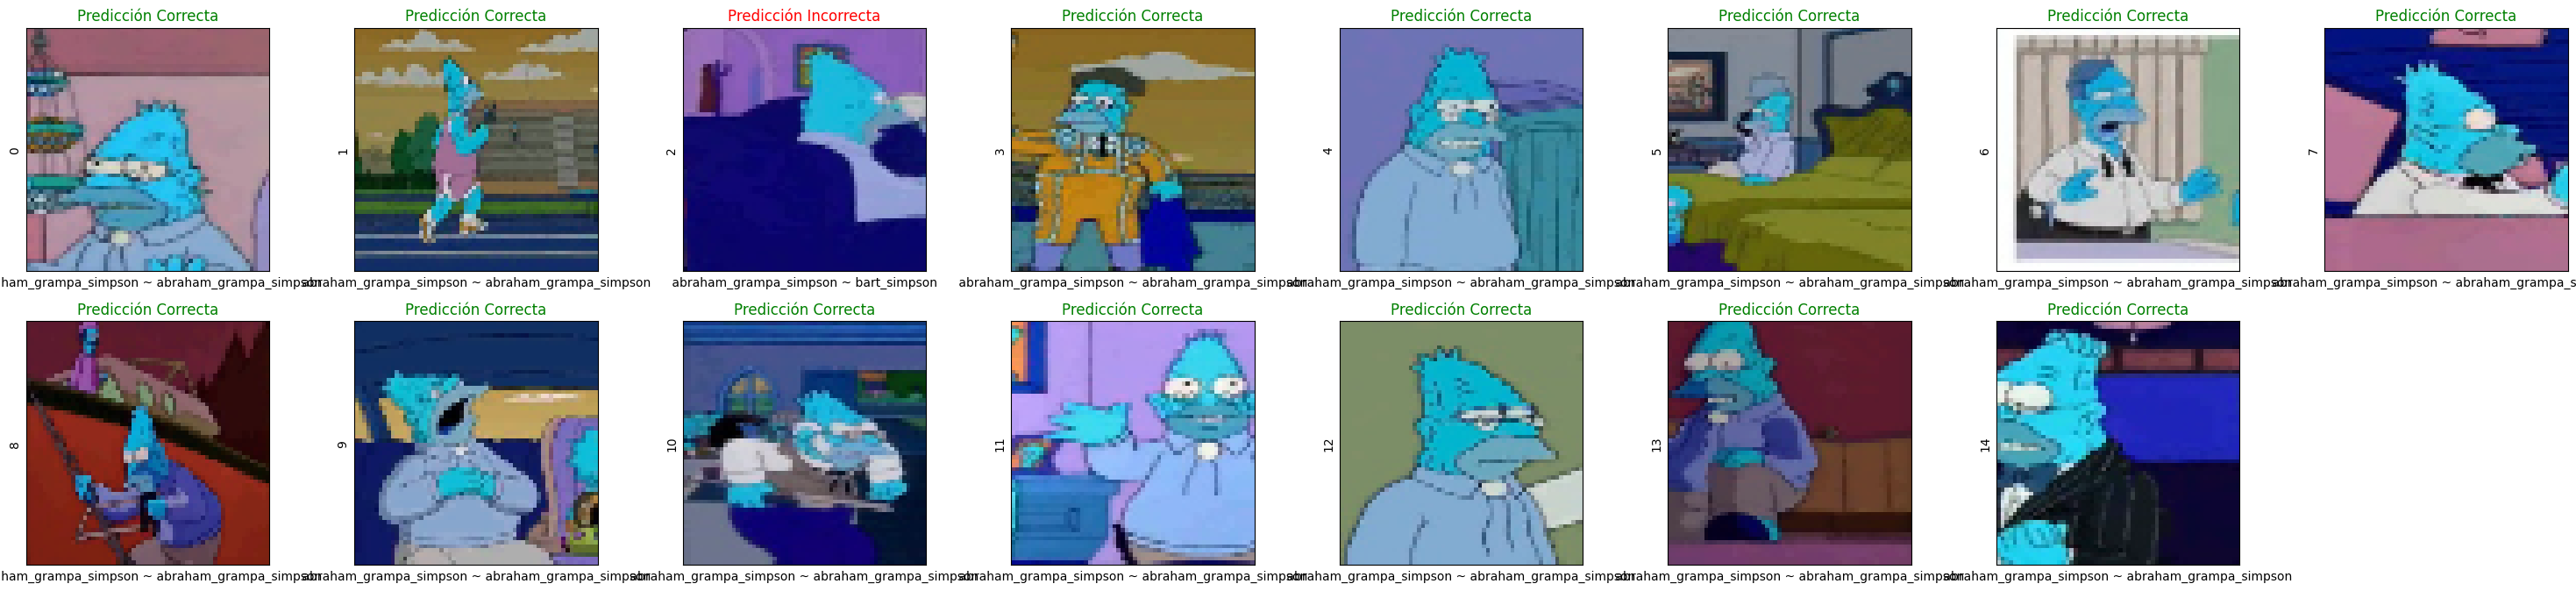

In [167]:
# GRÁFICO PARA PREDICCIONES

# Se realiza un gráfico para las predicciones en el cual se indica si la clasificación es correcta o no.

plt.figure(figsize=(30, 10))
i = 0
while i < 15:
    image, actual_label = X_t[i], y_t[i]
    predicted_label = np.argmax(predictions[i])
    plt.subplot(3, 8, i+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
        
    plt.imshow(image)
    
    if predicted_label == actual_label: 
      color, label = ('green', "Predicción Correcta")
    else:
      color, label = ('red', "Predicción Incorrecta") 
  
    plt.title(label, color=color)
      
    plt.xlabel(" {} ~ {} ".format(
        MAP_CHARACTERS[actual_label],
      MAP_CHARACTERS[predicted_label]))
       
    plt.ylabel(i)
   
    i += 1

In [168]:
# MATRIZ DE CONFUSIÓN
# Creación de la matriz de confusión
from sklearn.metrics import confusion_matrix
import numpy as np

confusion = confusion_matrix(y_t, np.argmax(predictions,axis=1))
confusion

array([[47,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0, 49,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
         0,  0],
       [ 1,  0, 42,  1,  1,  0,  0,  3,  1,  0,  0,  1,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0, 45,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0],
       [ 0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  3,  0, 44,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         2,  0],
       [ 1,  0,  1,  1,  0,  0, 44,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2, 48,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0, 49,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  5,  0,  0,  0,  0,  1,  0,  0, 44,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  

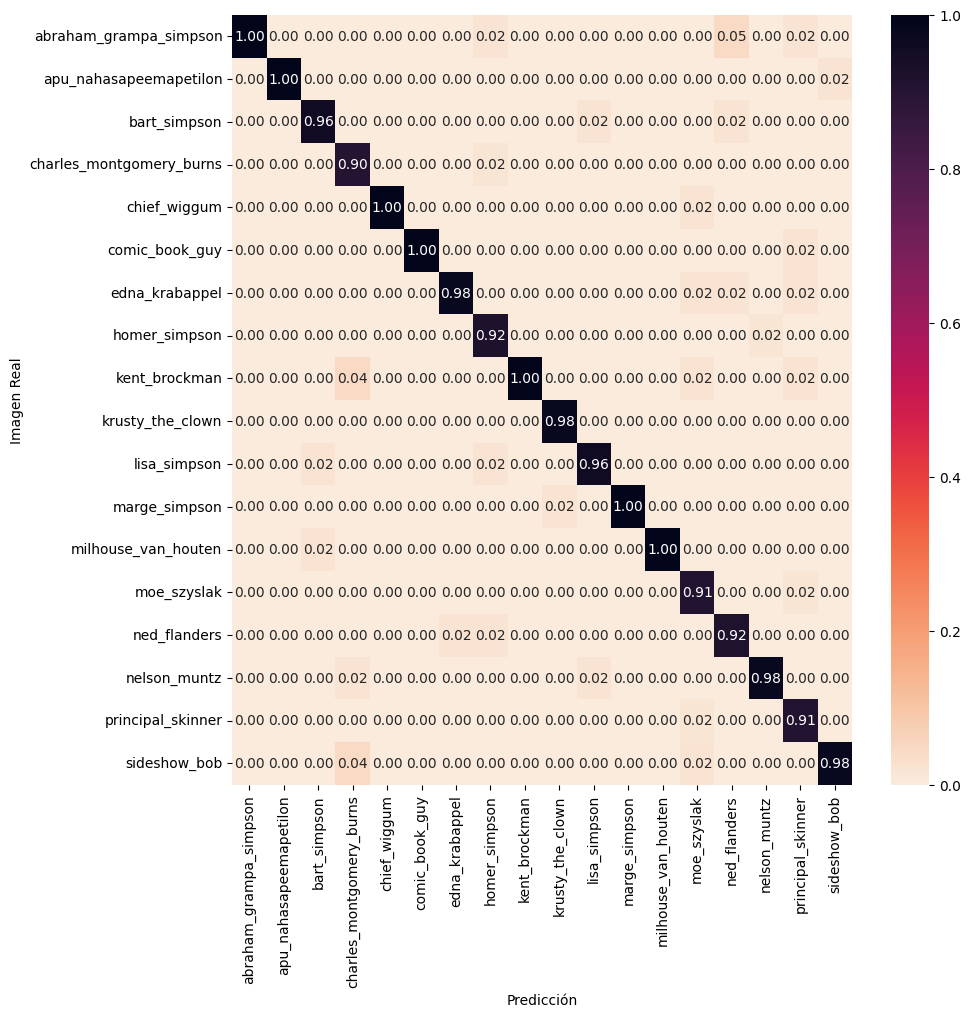

In [66]:
import seaborn as sns
# normalize the matrix to be in percentages
confusion = confusion.astype('float') / confusion.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion, annot=True, fmt='.2f', 
            xticklabels=[MAP_CHARACTERS[c] for c in MAP_CHARACTERS], 
            yticklabels=[MAP_CHARACTERS[c] for c in MAP_CHARACTERS],
            # cmap="Blues"
            cmap="rocket_r"
            )
plt.ylabel('Imagen Real')
plt.xlabel('Predicción')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")
# plt.show()

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=True,     
        vertical_flip=False)

In [ ]:
datagen.fit(X_train)
    
history = model.fit_generator(datagen.flow(X,Y, batch_size=batch_size),
                              steps_per_epoch=len(X) / 32, 
                              epochs=epochs,validation_data=(X_t, Y),
                              nb_val_samples=0.2)

# evalua los indicadores de loss y accuracy
score = model.evaluate(X_t,Y, verbose=0)
print('\nKeras CNN - accuracy:', score[1])
print('')

# genera las salidas predichas para los ejemplo de ingreso
y_pred = model.predict(X_test)
print('\n', metrics.classification_report(
    np.where(Y_test > 0)[1], np.argmax(y_pred, axis=1), 
    target_names=list(MAP_CHARACTERS.values())), sep='') 

Y_pred_classes = np.argmax(y_pred, axis = 1) 
Y_true = np.argmax(Y_test, axis = 1)

NameError: name 'X_train' is not defined

In [42]:
tf.__version__

'2.10.1'